Copyright (c) 2021-2024, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

In this notebook we will go over some examples to show how to use cuTensorNet to execute advanced quantum algorithms in Cirq. 
The topics we'll cover include:
 - Create a biased sampler
 - Compute the expectation values

In [1]:
import itertools

import cirq
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import sympy

from cuquantum import contract, contract_path, CircuitToEinsum
from cuquantum import cutensornet as cutn

np.random.seed(1000)

# Biased Sampler

Let's first create a parameterized entangled circuit as our sampler.

In [2]:
def add_entangled_layers(qubits, n_layer):
    n_qubits = len(qubits)
    for _ in range(n_layer):
        rads = np.random.random(n_qubits)
        for i, q in enumerate(qubits):
            yield cirq.rx(rads[i])(q)
        for i, q in enumerate(qubits[1::2]):
            yield cirq.CX(qubits[i-1], q)

num_qubits = 6
n_layer = 4
circuit = cirq.Circuit(add_entangled_layers(cirq.LineQubit.range(num_qubits), n_layer))
print(circuit)

                   ┌─────────────────────┐   ┌────────────────────┐   ┌───────────┐   ┌────────────────────┐   ┌──┐                ┌──┐
0: ───Rx(0.208π)─────@────────────────────────Rx(0.013π)─────────────────────────@─────Rx(0.125π)────────────────@────Rx(0.296π)─────@─────────────────────────────
                     │                                                           │                               │                   │
1: ───Rx(0.037π)────X┼────────────────────────@────────────────────────Rx(0.126π)┼─────X────────────────────────@┼────Rx(0.058π)────X┼────@───Rx(0.132π)───X───@───
                    ││                        │                                  │     │                        ││                  ││    │                │   │
2: ───Rx(0.302π)────┼┼─────────Rx(0.074π)─────┼─────────Rx(0.237π)─────Rx(0.009π)┼─────┼────────────────────────┼┼──────────────────┼┼────┼────────────────┼───┼───
                    ││                        │                             

Now we compute the marginal probabilities for qubits 0 & 4, subject to qubit 1 being in state 0 and qubit 2 in state 1.

In [3]:
myconverter = CircuitToEinsum(circuit, dtype='complex128', backend=cp)

qubits = sorted(circuit.all_qubits())
where = (qubits[0], qubits[4])
fixed = {qubits[1]: '0',
         qubits[2]: '1'}  # setting fixed=None will generate unbiased probablity
expression, operands = myconverter.reduced_density_matrix(where, fixed=fixed)
rdm = contract(expression, *operands)
    
n_sites = len(where)
sh = 2 ** n_sites
prob = abs(rdm.reshape(sh, sh).diagonal())**2
marginal = prob.reshape((2,)*n_sites) / prob.sum()  # normalization

# print the probabilities
print(marginal)

[[0.02869503 0.73300057]
 [0.00897754 0.22932686]]



10000 samples on (cirq.LineQubit(0), cirq.LineQubit(4)) assuming:
  - qubit 1 is fixed at state 0
  - qubit 2 is fixed at state 1


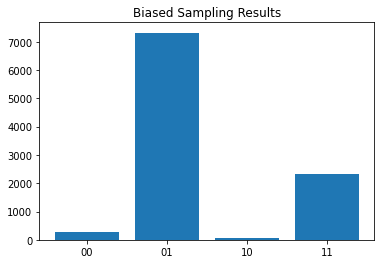

In [4]:
def create_samples(marginal, nsample):
    # this function generates samples on CPU, since we are sampling over Python strings 
    nqubits = marginal.ndim    
    bitstrings = [''.join(bitstring) for bitstring in itertools.product('01', repeat=nqubits)]
    ps = cp.asnumpy(marginal.flatten())
    return np.random.choice(bitstrings, size=nsample, p=ps)

nsample = 10000
samples = create_samples(marginal, nsample)
keys, counts = np.unique(samples, return_counts=True)

print(f'\n{nsample} samples on {where} assuming:')
for q, state in fixed.items():
    print(f'  - qubit {q} is fixed at state {state}')

# plot the result; note the keys are already sorted by numpy.unique() 
plt.bar(keys, counts)
plt.title('Biased Sampling Results')
plt.show()

# Expectation Value Computation

In this section, we will compute expectation values using the VQE example taken from [this Cirq tutorial](https://quantumai.google/cirq/tutorials/variational_algorithm). 

We first define a set of functions that specify the circuit ansatz.

In [5]:
# define the length and width of a 2D grid
length = 3

def rot_x_layer(length, half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""

    # Define the gate once and then re-use it for each Operation.
    rot = cirq.XPowGate(exponent=half_turns)

    # Create an X rotation Operation for each qubit in the grid.
    for i in range(length):
        for j in range(length):
            yield rot(cirq.GridQubit(i, j))

def prepare_plus_layer(length):
    for i in range(length):
        for j in range(length):
            yield cirq.H(cirq.GridQubit(i, j))
    
def rot_z_layer(h, half_turns):
    """Yields Z rotations by half_turns conditioned on the field h."""
    gate = cirq.ZPowGate(exponent=half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij == 1:
                yield gate(cirq.GridQubit(i, j))

def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    cz_gate = cirq.CZPowGate(exponent=half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i + 1, j)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i, j + 1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

def initial_step(length):
    yield prepare_plus_layer(length)

def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
    length = len(h)
    yield rot_z_layer(h, h_half_turns)
    yield rot_11_layer(jr, jc, j_half_turns)
    yield rot_x_layer(length, x_half_turns)

The following functions can generate a random 2D spin Hamiltonian for the cost function.

In [6]:
def rand2d(rows, cols):
    return np.random.choice((1, -1), size=rows*cols).reshape(rows, cols)

def random_instance(length):
    # transverse field terms
    h = rand2d(length, length)
    # links within a row
    jr = rand2d(length - 1, length)
    # links within a column
    jc = rand2d(length, length - 1)
    return (h, jr, jc)


h, jr, jc = random_instance(length)
print(f'transverse fields:\n{h}')
print(f'row j fields:\n{jr}')
print(f'column j fields:\n{jc}')

transverse fields:
[[ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]]
row j fields:
[[-1  1  1]
 [-1  1 -1]]
column j fields:
[[ 1 -1]
 [ 1  1]
 [ 1 -1]]


Now we can generate a parameterized circuit using `sympy`.

In [7]:
circuit = cirq.Circuit()
alpha = sympy.Symbol('alpha')
beta = sympy.Symbol('beta')
gamma = sympy.Symbol('gamma')
circuit.append(initial_step(len(h)))
circuit.append(one_step(h, jr, jc, alpha, beta, gamma))
qubits = sorted(circuit.all_qubits())
circuit.append(cirq.measure(*qubits, key='x'))
print(circuit)

                        ┌───────────────┐   ┌────────┐
(0, 0): ───H───Z^beta────X───────────────────@───────────X─────────@─────────X^alpha─────────────────────────────────────────────────────────M('x')───
                                             │                     │                                                                         │
(0, 1): ───H──────────────@──────────────────┼─────────────────────@^gamma───X─────────@─────────X─────────X^alpha───────────────────────────M────────
                          │                  │                                         │                                                     │
(0, 2): ───H──────────────┼──────@───────────┼──────X──────────────────────────────────@^gamma───X─────────X^alpha───────────────────────────M────────
                          │      │           │                                                                                               │
(1, 0): ───H───Z^beta────X┼──────┼───────────@^gamma─────X─────

We can use `CircuitToEinsum.reduced_density_matrix()` to compute the exact energy for each Hamiltonian term and sum over all terms to yield the total energy.

In [8]:
def compute_energy_cutn(resolved_circuit, length, h, jr, jc):
    nrow = ncol = length
    assert length == jr.shape[1] == jc.shape[0]
    
    def compute_energy_term(myconverter, pauli_string, options):
        expression, operands = myconverter.expectation(pauli_string, lightcone=True)
        e = contract(expression, *operands, options=options).real
        return e
    
    def expectation(x):
        energy = 0.
        
        # trick: reuse the cuTensorNet library handle to reduce overhead
        handle = cutn.create()
        options = {'handle': handle}
    
        myconverter = CircuitToEinsum(resolved_circuit, dtype='complex128', backend=cp)
        
        for i in range(nrow):
            for j in range(ncol):
                # one-body terms
                q = qubits[i*ncol+j]
                pauli_string = {q: 'Z'}
                energy += compute_energy_term(myconverter, pauli_string, options) * h[i][j]
                
                # two-body terms
                #   - vertical bond
                if i != nrow-1:
                    top = qubits[i*ncol+j]
                    bottom = qubits[(i+1)*ncol+j]
                    pauli_string = {top: 'Z', bottom: 'Z'}
                    energy += compute_energy_term(myconverter, pauli_string, options) * jr[i][j]
                    
                #   - horizontal bond
                if j != ncol-1:
                    left = qubits[i*ncol+j]
                    right = qubits[i*ncol+(j+1)]
                    pauli_string = {left:'Z', right:'Z'}
                    energy += compute_energy_term(myconverter, pauli_string, options) * jc[i][j]
    
        # handle should be explictly destroyed
        cutn.destroy(handle)
        
        return cp.asnumpy(energy)
    
    return expectation


# let's try the circuit with random numbers filling alpha, beta and gamma
params = (alpha, beta, gamma)
param_values = np.random.random(3)
resolved_circuit = cirq.resolve_parameters(circuit, dict(zip(params, param_values)))

# set up and run the cutn calculation
expectation_cutn = compute_energy_cutn(resolved_circuit, length, h, jr, jc)
energy_cutn = expectation_cutn(param_values)
print(f'Exact energy from cutn: {energy_cutn}')

Exact energy from cutn: 0.4444829524537696


With Cirq's simulator, expectation values are computed in a different manner. One needs to perform a number of sampling and compute the expectation value statistically.

In [9]:
def energy_func(length, h, jr, jc):
    
    def energy(measurements):
        # Reshape measurement into array that matches grid shape.
        meas_list_of_lists = [measurements[i * length:(i + 1) * length]
                              for i in range(length)]
        # Convert true/false to +1/-1.
        pm_meas = 1 - 2 * np.array(meas_list_of_lists).astype(np.int32)
        
        tot_energy = np.sum(pm_meas * h)
        for i, jr_row in enumerate(jr):
            for j, jr_ij in enumerate(jr_row):
                tot_energy += jr_ij * pm_meas[i, j] * pm_meas[i + 1, j]
        for i, jc_row in enumerate(jc):
            for j, jc_ij in enumerate(jc_row):
                tot_energy += jc_ij * pm_meas[i, j] * pm_meas[i, j + 1]
        return tot_energy
        
    return energy

def obj_func(results, length, h, jr, jc):
    energy_hist = results.histogram(key='x', fold_func=energy_func(length, h, jr, jc))
    return np.sum([k * v for k,v in energy_hist.items()]) / results.repetitions


simulator = cirq.Simulator(dtype=np.complex128)
nsamples = np.arange(1000, 80000, 4000)
energy_cirq = []
for repetitions in nsamples:
    results = simulator.run(resolved_circuit, repetitions=repetitions)
    energy_cirq.append(obj_func(results, length, h, jr, jc))

We can plot the convergence of sampling versus the exact expectation value computed by `cuquantum.contract`

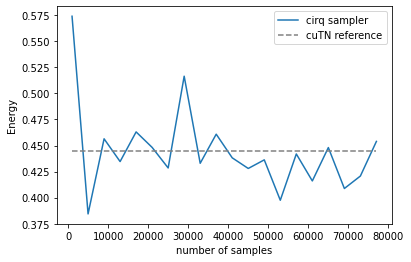

In [10]:
plt.plot(nsamples, energy_cirq, label='cirq sampler')
plt.hlines(energy_cutn, nsamples[0], nsamples[-1], color='grey', linestyle='--', label='cuTN reference')
plt.xlabel('number of samples')
plt.ylabel('Energy')
plt.legend()
plt.show()